### 연습 문제 5.6.

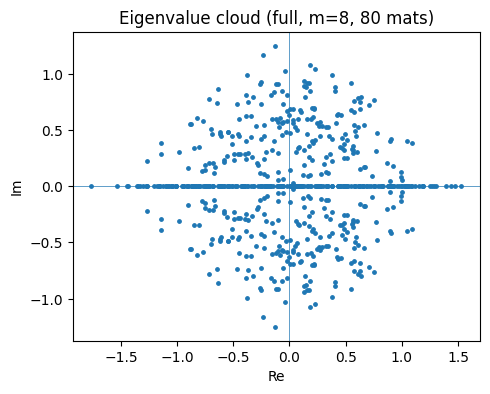

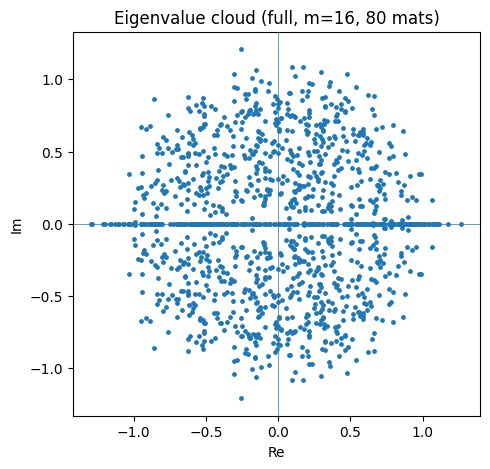

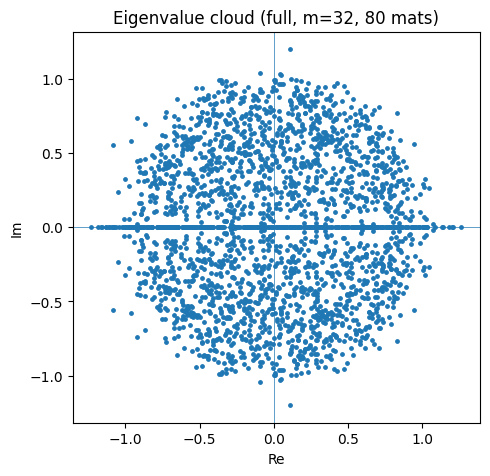

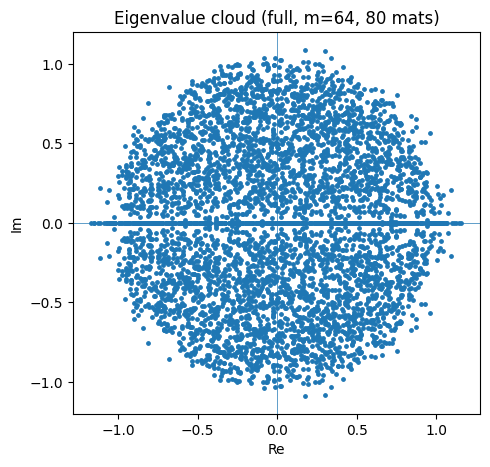

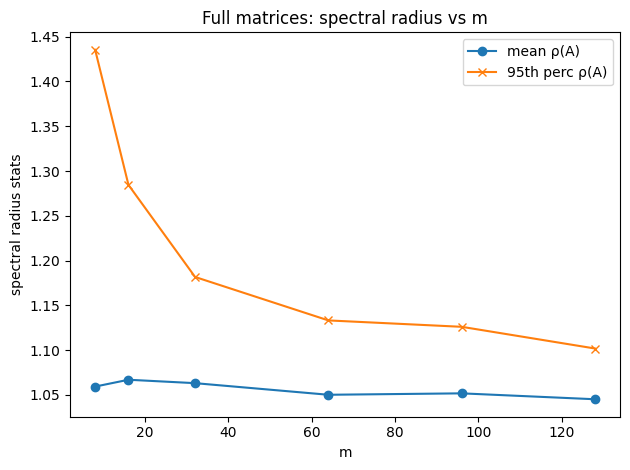

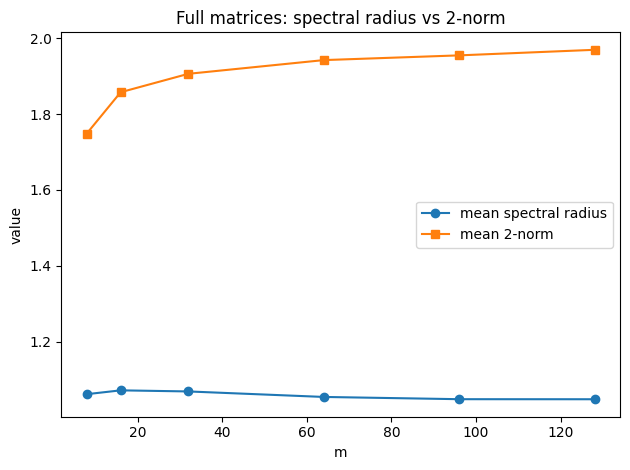


Smallest singular value proportions (full):
             m |         trials |  P(smin<= 0.5) | P(smin<= 0.25) | P(smin<= 0.125) | P(smin<= 0.5/m) | P(smin<= 0.25/m) | P(smin<= 0.125/m)
            16 |            400 |       1.000000 |       1.000000 |       0.980000 |       0.447500 |       0.222500 |       0.120000
            32 |            400 |       1.000000 |       1.000000 |       1.000000 |       0.425000 |       0.225000 |       0.140000
            64 |            400 |       1.000000 |       1.000000 |       1.000000 |       0.507500 |       0.267500 |       0.137500
           128 |            400 |       1.000000 |       1.000000 |       1.000000 |       0.455000 |       0.250000 |       0.107500


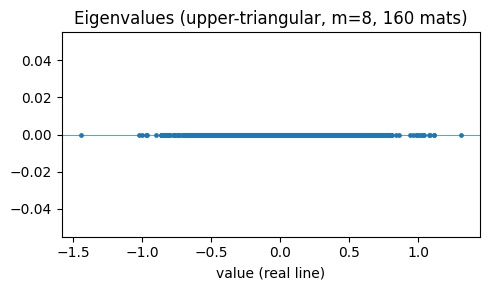

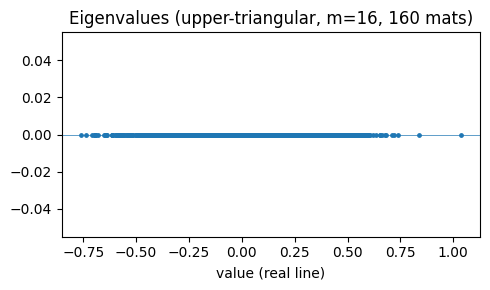

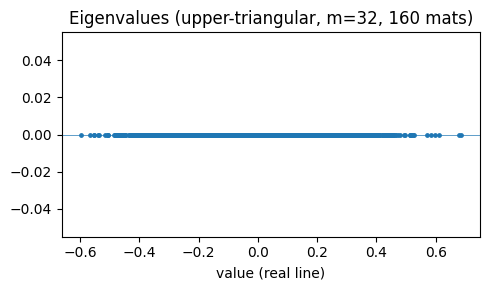

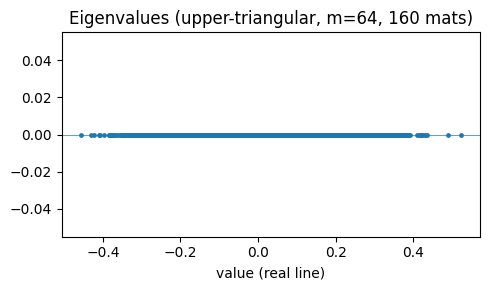

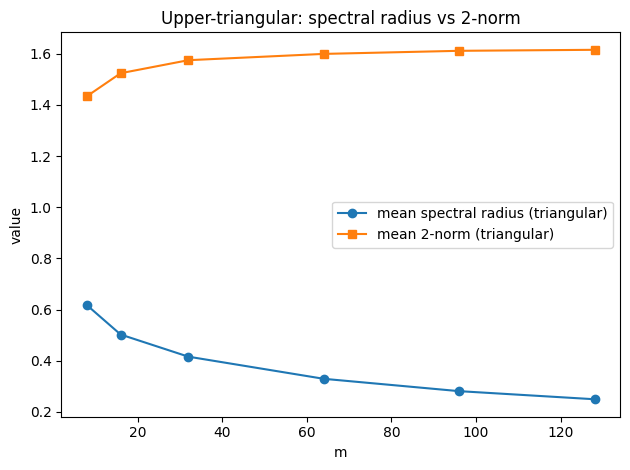


Saved figure files:
  - eig_cloud_full_m{8,16,32,64}.png
  - spectral_radius_trend_full.png
  - radius_vs_norm_full.png
  - eig_cloud_tri_m{8,16,32,64}.png
  - radius_vs_norm_tri.png


In [1]:
# Random-matrix experiments (Ginibre scaling) and triangular variants
# ---------------------------------------------------------------
# Requires: numpy, matplotlib
# Optional (for nice tables): nothing else
#
# (a) eigenvalue clouds & spectral radius trend
# (b) 2-norm vs spectral radius
# (c) proportions for smallest singular value thresholds
# (d) repeat (a)-(c) ideas for random upper-triangular matrices

import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt


# -----------------------------
# Random generators
# -----------------------------
rng = np.random.default_rng(7)

def rand_full(m, n=None):
    """Full random matrix with entries ~ N(0, 1/m)."""
    if n is None:
        n = m
    return rng.standard_normal((m, n)) / np.sqrt(m)

def rand_upper_tri(m):
    """Upper-triangular random matrix with entries ~ N(0, 1/m)."""
    A = rng.standard_normal((m, m)) / np.sqrt(m)
    return np.triu(A)


# -----------------------------
# (a) Eigenvalue clouds & spectral radius
# -----------------------------
def eig_cloud_full(m, n_mats=100, save_path=None):
    """Superimpose eigenvalues of n_mats full random matrices of size m."""
    xs, ys = [], []
    for _ in range(n_mats):
        A = rand_full(m)
        ev = la.eigvals(A)
        xs.extend(ev.real.tolist())
        ys.extend(ev.imag.tolist())
    plt.figure(figsize=(5, 5))
    plt.scatter(xs, ys, s=6)
    plt.axhline(0, linewidth=0.5)
    plt.axvline(0, linewidth=0.5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(f'Eigenvalue cloud (full, m={m}, {n_mats} mats)')
    plt.xlabel('Re')
    plt.ylabel('Im')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()

def spectral_radius_stats_full(m_vals, n_mats=200, save_path=None):
    """Compute mean and 95th percentile of spectral radius over sizes m_vals."""
    means, p95s = [], []
    for m in m_vals:
        rhos = []
        for _ in range(n_mats):
            A = rand_full(m)
            ev = la.eigvals(A)
            rhos.append(np.max(np.abs(ev)))
        means.append(float(np.mean(rhos)))
        p95s.append(float(np.percentile(rhos, 95)))
    means = np.array(means)
    p95s = np.array(p95s)

    plt.figure()
    plt.plot(m_vals, means, marker='o', label='mean ρ(A)')
    plt.plot(m_vals, p95s, marker='x', label='95th perc ρ(A)')
    plt.xlabel('m')
    plt.ylabel('spectral radius stats')
    plt.title('Full matrices: spectral radius vs m')
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()
    return means, p95s


# -----------------------------
# (b) 2-norm vs spectral radius (full)
# -----------------------------
def norms_vs_radius_full(m_vals, n_mats=200, save_path=None):
    rho_mean = []
    norm_mean = []
    for m in m_vals:
        rhos, norms = [], []
        for _ in range(n_mats):
            A = rand_full(m)
            ev = la.eigvals(A)
            rhos.append(np.max(np.abs(ev)))
            svals = la.svd(A, compute_uv=False)
            norms.append(svals[0])
        rho_mean.append(np.mean(rhos))
        norm_mean.append(np.mean(norms))

    rho_mean = np.array(rho_mean)
    norm_mean = np.array(norm_mean)

    plt.figure()
    plt.plot(m_vals, rho_mean, marker='o', label='mean spectral radius')
    plt.plot(m_vals, norm_mean, marker='s', label='mean 2-norm')
    plt.xlabel('m')
    plt.ylabel('value')
    plt.title('Full matrices: spectral radius vs 2-norm')
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()
    return rho_mean, norm_mean


# -----------------------------
# (c) Smallest singular value proportions (full)
# -----------------------------
def smallest_sv_proportions(m_vals, thresholds_abs=(0.5, 0.25, 0.125), n_mats=1000):
    """
    For each m in m_vals, estimate:
      P(smin <= t)  for t in thresholds_abs
      P(smin <= t/m) for the same t (scale-aware thresholds)
    Prints a simple table and returns a dict of results.
    """
    results = {}
    for m in m_vals:
        counts_abs = {t: 0 for t in thresholds_abs}
        counts_scaled = {t: 0 for t in thresholds_abs}
        for _ in range(n_mats):
            A = rand_full(m)
            svals = la.svd(A, compute_uv=False)
            smin = svals[-1]
            for t in thresholds_abs:
                if smin <= t:
                    counts_abs[t] += 1
                if smin <= (t / m):
                    counts_scaled[t] += 1
        res = {
            'trials': n_mats,
            **{f'P(smin<= {t})': counts_abs[t] / n_mats for t in thresholds_abs},
            **{f'P(smin<= {t}/m)': counts_scaled[t] / n_mats for t in thresholds_abs},
        }
        results[m] = res

    # Pretty print
    hdr = ["m", "trials"] + [f"P(smin<= {t})" for t in thresholds_abs] + [f"P(smin<= {t}/m)" for t in thresholds_abs]
    print("\nSmallest singular value proportions (full):")
    print(" | ".join(f"{h:>14s}" for h in hdr))
    for m in m_vals:
        row = [m, results[m]['trials']]
        row += [results[m][f'P(smin<= {t})'] for t in thresholds_abs]
        row += [results[m][f'P(smin<= {t}/m)'] for t in thresholds_abs]
        print(" | ".join(f"{x:14.6f}" if isinstance(x, float) else f"{x:14d}" for x in row))
    return results


# -----------------------------
# (d) Triangular analogs
# -----------------------------
def eig_cloud_tri(m, n_mats=200, save_path=None):
    """Eigenvalues of random upper-triangular matrices (diagonals)."""
    vals = []
    for _ in range(n_mats):
        T = rand_upper_tri(m)
        vals.extend(np.diag(T).tolist())
    plt.figure(figsize=(5, 3))
    plt.scatter(vals, np.zeros_like(vals), s=6)
    plt.axhline(0, linewidth=0.5)
    plt.xlabel('value (real line)')
    plt.title(f'Eigenvalues (upper-triangular, m={m}, {n_mats} mats)')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()

def norms_vs_radius_tri(m_vals, n_mats=200, save_path=None):
    rho_mean = []
    norm_mean = []
    for m in m_vals:
        rhos, norms = [], []
        for _ in range(n_mats):
            T = rand_upper_tri(m)
            rhos.append(np.max(np.abs(np.diag(T))))  # spectral radius = max |diag|
            svals = la.svd(T, compute_uv=False)
            norms.append(svals[0])
        rho_mean.append(np.mean(rhos))
        norm_mean.append(np.mean(norms))
    rho_mean = np.array(rho_mean)
    norm_mean = np.array(norm_mean)

    plt.figure()
    plt.plot(m_vals, rho_mean, marker='o', label='mean spectral radius (triangular)')
    plt.plot(m_vals, norm_mean, marker='s', label='mean 2-norm (triangular)')
    plt.xlabel('m')
    plt.ylabel('value')
    plt.title('Upper-triangular: spectral radius vs 2-norm')
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()
    return rho_mean, norm_mean


# -----------------------------
# Example run
# -----------------------------
if __name__ == "__main__":
    # (a) eigenvalue clouds for full matrices
    for m in [8, 16, 32, 64]:
        eig_cloud_full(m, n_mats=80, save_path=f'eig_cloud_full_m{m}.png')

    # (a) spectral radius trend
    m_vals = np.array([8, 16, 32, 64, 96, 128])
    spectral_radius_stats_full(m_vals, n_mats=200, save_path='spectral_radius_trend_full.png')

    # (b) norms vs spectral radius (full)
    norms_vs_radius_full(m_vals, n_mats=200, save_path='radius_vs_norm_full.png')

    # (c) smallest singular value proportions (full)
    smallest_sv_proportions([16, 32, 64, 128], thresholds_abs=(0.5, 0.25, 0.125), n_mats=400)

    # (d) triangular case: eigenvalue plots and norm/radius summary
    for m in [8, 16, 32, 64]:
        eig_cloud_tri(m, n_mats=160, save_path=f'eig_cloud_tri_m{m}.png')
    norms_vs_radius_tri(m_vals, n_mats=200, save_path='radius_vs_norm_tri.png')

    print("\nSaved figure files:")
    print("  - eig_cloud_full_m{8,16,32,64}.png")
    print("  - spectral_radius_trend_full.png")
    print("  - radius_vs_norm_full.png")
    print("  - eig_cloud_tri_m{8,16,32,64}.png")
    print("  - radius_vs_norm_tri.png")


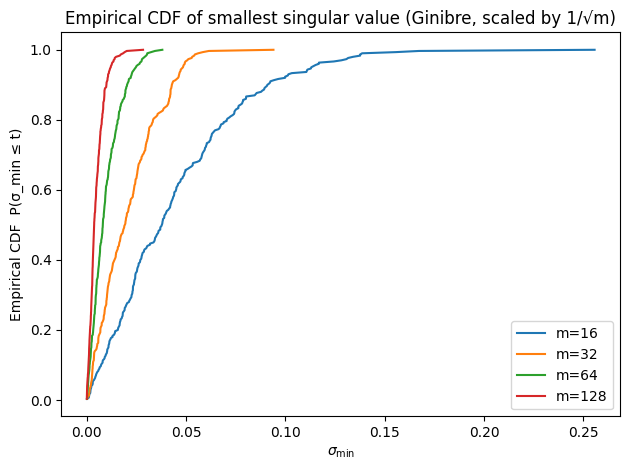

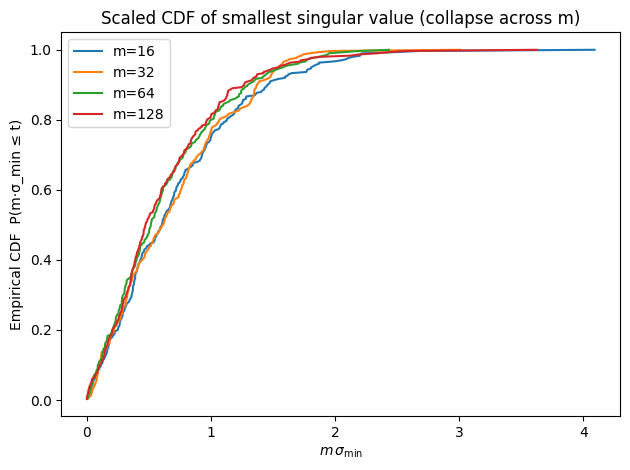

m= 16 | median σ_min ≈ 0.0379 | median (m·σ_min) ≈ 0.606
m= 32 | median σ_min ≈ 0.0193 | median (m·σ_min) ≈ 0.617
m= 64 | median σ_min ≈ 0.0081 | median (m·σ_min) ≈ 0.517
m=128 | median σ_min ≈ 0.0037 | median (m·σ_min) ≈ 0.474


In [2]:
# (c) Plot the "tail & scale" of the smallest singular value (σ_min)
# for real Ginibre matrices scaled by 1/sqrt(m).
# Two figures:
#   1) Empirical CDF of σ_min for m in {16, 32, 64, 128}
#   2) Empirical CDF of m * σ_min (scaled), showing curve collapse across m
#
# Requirements: numpy, matplotlib

import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

# -----------------------------
# Utilities
# -----------------------------
rng = np.random.default_rng(2025)

def rand_full(m: int) -> np.ndarray:
    """m×m real Ginibre matrix with entries ~ N(0, 1/m)."""
    return rng.standard_normal((m, m)) / np.sqrt(m)

def sample_smin(m: int, trials: int = 300) -> np.ndarray:
    """Collect 'trials' samples of the smallest singular value for size m."""
    out = np.empty(trials, dtype=float)
    for t in range(trials):
        A = rand_full(m)
        svals = la.svd(A, compute_uv=False)   # singular values (descending)
        out[t] = svals[-1]                    # smallest singular value
    return out

def ecdf(x: np.ndarray):
    """Empirical CDF points for array x (sorted x, uniform CDF steps)."""
    x_sorted = np.sort(np.asarray(x))
    y = np.arange(1, x_sorted.size + 1) / x_sorted.size
    return x_sorted, y

# -----------------------------
# Main experiment
# -----------------------------
m_list = [16, 32, 64, 128]
trials = 300

# Collect samples
samples_raw = {m: sample_smin(m, trials=trials) for m in m_list}
samples_scaled = {m: m * samples_raw[m] for m in m_list}

# 1) Empirical CDF of σ_min
plt.figure()
for m in m_list:
    x, y = ecdf(samples_raw[m])
    plt.plot(x, y, label=f"m={m}")
plt.xlabel(r"$\sigma_{\min}$")
plt.ylabel("Empirical CDF  P(σ_min ≤ t)")
plt.title("Empirical CDF of smallest singular value (Ginibre, scaled by 1/√m)")
plt.legend()
plt.tight_layout()
plt.savefig("smin_cdf_raw.png", dpi=150)
plt.show()

# 2) Empirical CDF of m * σ_min (scaled)
plt.figure()
for m in m_list:
    x, y = ecdf(samples_scaled[m])
    plt.plot(x, y, label=f"m={m}")
plt.xlabel(r"$m\,\sigma_{\min}$")
plt.ylabel("Empirical CDF  P(m·σ_min ≤ t)")
plt.title("Scaled CDF of smallest singular value (collapse across m)")
plt.legend()
plt.tight_layout()
plt.savefig("smin_cdf_scaled.png", dpi=150)
plt.show()

# Quick numeric summaries
for m in m_list:
    med_raw = float(np.median(samples_raw[m]))
    med_scaled = float(np.median(samples_scaled[m]))
    print(f"m={m:3d} | median σ_min ≈ {med_raw:.4f} | median (m·σ_min) ≈ {med_scaled:.3f}")


### 연습 문제 5.7.

In [3]:
import numpy as np
import numpy.linalg as la

np.set_printoptions(precision=15, suppress=False, linewidth=180)

m, n = 50, 12
t = np.linspace(0.0, 1.0, m)
A = np.vander(t, N=n, increasing=True)  # [1, t, t^2, ..., t^(n-1)]
b = np.cos(4.0 * t)

# (a) Normal equations
AtA = A.T @ A
Atb = A.T @ b
x_ne = la.solve(AtA, Atb)

# (b) MGS-QR
def mgs(A):
    A = np.array(A, dtype=float)
    m, n = A.shape
    V = A.copy()
    Q = np.zeros((m, n), dtype=float)
    R = np.zeros((n, n), dtype=float)
    for j in range(n):
        v = V[:, j]
        R[j, j] = la.norm(v)
        Q[:, j] = v / R[j, j]
        for k in range(j + 1, n):
            R[j, k] = Q[:, j] @ V[:, k]
            V[:, k] -= R[j, k] * Q[:, j]
    return Q, R

def backsolve(R, y):
    n = R.shape[0]
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        x[i] = (y[i] - R[i, i+1:] @ x[i+1:]) / R[i, i]
    return x

Qm, Rm = mgs(A)
x_mgs = backsolve(Rm, Qm.T @ b)

# (c) Householder QR (ours)
def qr_householder(A):
    A = np.array(A, dtype=float)
    m, n = A.shape
    R = A.copy()
    Q = np.eye(m)
    for j in range(n):
        x = R[j:, j]
        normx = la.norm(x)
        if normx == 0:
            continue
        alpha = -np.copysign(normx, x[0])
        v = x.copy(); v[0] -= alpha; v /= la.norm(v)
        R[j:, :] -= 2.0 * np.outer(v, v @ R[j:, :])
        Q[:, j:] -= 2.0 * np.outer(Q[:, j:] @ v, v)
    return Q, R[:n, :]

Qh, Rh = qr_householder(A)
x_hh = backsolve(Rh[:, :n], (Qh.T @ b)[:n])

# (d) NumPy QR
Qn, Rn = la.qr(A, mode='reduced')
x_qrnp = backsolve(Rn, Qn.T @ b)

# (e) lstsq (≈ “\”)
x_lstsq, resid, rank, s_lstsq = la.lstsq(A, b, rcond=None)

# (f) SVD solve
U, S, VT = la.svd(A, full_matrices=False)
tol = np.finfo(float).eps * max(A.shape) * S[0]
Sinv = np.array([1/s if s > tol else 0.0 for s in S])
x_svd = (VT.T * Sinv) @ (U.T @ b)

def resid_norm(x): return la.norm(A @ x - b)

labels   = ["(a) normal eqns","(b) MGS-QR","(c) Householder-QR","(d) NumPy-QR","(e) lstsq","(f) SVD"]
solutions= [x_ne, x_mgs, x_hh, x_qrnp, x_lstsq, x_svd]
resids   = [resid_norm(x) for x in solutions]

print("=== Coefficient vectors x (degree 0..11), 15 digits ===")
for lab, x in zip(labels, solutions):
    print(f"{lab:>18s}: {x}")

print("\n=== Residual 2-norms ||Ax-b|| ===")
for lab, r in zip(labels, resids):
    print(f"{lab:>18s}: {r:.12e}")

print("\nSingular values of A (desc):")
print(S)
print(f"\ncond2(A) ≈ {S[0]/S[-1]:.6e},  rank = {rank}")

# (g) “잘못된 자리수” 가늠: SVD 해 대비 상대오차의 -log10 값(대략 유효자릿수)
eps = np.finfo(float).eps
def rel_digits(x, xref):
    d = np.zeros_like(xref)
    for i in range(xref.size):
        denom = max(abs(xref[i]), 10*eps)
        rel = abs(x[i] - xref[i]) / denom
        d[i] = 16.0 if rel <= 0 else -np.log10(rel)
    return d

print("\n=== Estimated correct significant digits vs SVD (per coefficient) ===")
for lab, x in zip(labels, solutions):
    d = rel_digits(x, x_svd)
    print(f"{lab:>18s}: {np.round(d,1)}")

med_digits = [np.median(rel_digits(x, x_svd)) for x in solutions]
print("\nMedian of estimated correct digits (higher is better):")
for lab, md in zip(labels, med_digits):
    print(f"{lab:>18s}: {md:.2f}")

print("\nlog10 residuals:")
for lab, r in zip(labels, resids):
    print(f"{lab:>18s}: {np.log10(r): .3f}")


=== Coefficient vectors x (degree 0..11), 15 digits ===
   (a) normal eqns: [ 9.999999739908689e-01  7.664989151809260e-06 -8.000286895225596e+00  4.205217402677350e-03  1.063467603125544e+01  1.434647068343356e-01 -6.094063712212618e+00
  7.448956439053251e-01  7.228423589415738e-01  7.216715251246547e-01 -6.730872691439164e-01  1.420311539314968e-01]
        (b) MGS-QR: [ 9.999999974886991e-01  6.109656305667071e-07 -8.000020069316570e+00  2.536139335420244e-04  1.066504757465189e+01  5.965952600617826e-03 -5.703189150096881e+00
  2.747163101208916e-02  1.572132229567180e+00  9.546817416081917e-02 -4.115481095943990e-01  9.477392743482521e-02]
(c) Householder-QR: [ 1.000000000996601e+00 -4.227429810439559e-07 -7.999981235684566e+00 -3.187632575846122e-04  1.066943079610625e+01 -1.382028890587174e-02 -5.647075624872106e+00
 -7.531602863588847e-02  1.693606968348364e+00  6.032105319023618e-03 -3.742417020603868e-01  8.804057582738772e-02]
      (d) NumPy-QR: [ 1.000000000996612e+00 -4.

### 연습 문제 7.3.

In [ ]:
# Phase portraits in x-space (diagonal/Jordan form) and y-space for:
#   y' = A y,  A = [[2, -3], [-12, 2]]
# with the change of variable y = P x so that P^{-1} A P = J = diag(8, -4).
#
# Requires: numpy, matplotlib

import numpy as np
import matplotlib.pyplot as plt


def main():
    # System matrix
    A = np.array([[2.0, -3.0],
                  [-12.0, 2.0]])

    # Eigen-decomposition (known for this matrix)
    # eigenvalues: 8 (v1=[1,-2]) and -4 (v2=[1,2])
    P = np.array([[1.0, 1.0],
                  [-2.0, 2.0]])          # columns = eigenvectors
    J = np.array([[8.0, 0.0],
                  [0.0, -4.0]])          # diagonal eigenvalue matrix

    # Sanity check: P^{-1} A P = J
    PinvAP = np.linalg.inv(P) @ A @ P
    print("P (columns = eigenvectors):\n", P)
    print("J (diagonal eigenvalue matrix):\n", J)
    print("Check P^{-1} A P (should equal J):\n", PinvAP)

    # -----------------------------
    # Phase portrait in x-space: x' = J x
    # -----------------------------
    x1 = np.linspace(-3, 3, 25)
    x2 = np.linspace(-3, 3, 25)
    X1, X2 = np.meshgrid(x1, x2)
    Ux = 8.0 * X1          # dx1/dt
    Vx = -4.0 * X2         # dx2/dt

    plt.figure(figsize=(6, 6))
    plt.streamplot(X1, X2, Ux, Vx, density=1.0, linewidth=1.0, arrowsize=1.0)
    plt.axhline(0, linewidth=0.8)
    plt.axvline(0, linewidth=0.8)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("x-space phase portrait (x' = J x)")

    # Overlay a few analytic trajectories in x-space
    t = np.linspace(-0.25, 0.25, 200)  # short window to avoid overflow
    inits_x = [
        np.array([1.0, 0.0]),
        np.array([0.0, 1.0]),
        np.array([0.8, 0.8]),
        np.array([-1.0, 0.5]),
        np.array([0.5, -1.0])
    ]
    for x0 in inits_x:
        xt = np.vstack([x0[0] * np.exp(8.0 * t),
                        x0[1] * np.exp(-4.0 * t)]).T
        plt.plot(xt[:, 0], xt[:, 1])

    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Phase portrait in y-space: y' = A y
    # -----------------------------
    y1 = np.linspace(-6, 6, 31)
    y2 = np.linspace(-6, 6, 31)
    Y1, Y2 = np.meshgrid(y1, y2)
    Uy = 2.0 * Y1 - 3.0 * Y2       # dy1/dt
    Vy = -12.0 * Y1 + 2.0 * Y2     # dy2/dt

    plt.figure(figsize=(6, 6))
    plt.streamplot(Y1, Y2, Uy, Vy, density=1.0, linewidth=1.0, arrowsize=1.0)
    plt.axhline(0, linewidth=0.8)
    plt.axvline(0, linewidth=0.8)
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("y-space phase portrait (y' = A y)")

    # Eigenvector lines in y-space (stable/unstable manifolds)
    s = np.linspace(-6, 6, 200)
    v1 = P[:, 0] / np.linalg.norm(P[:, 0])   # eigenvector for λ=8 (unstable)
    v2 = P[:, 1] / np.linalg.norm(P[:, 1])   # eigenvector for λ=-4 (stable)
    plt.plot(s * v1[0], s * v1[1], linewidth=1.5)
    plt.plot(s * v2[0], s * v2[1], linewidth=1.5)

    # Overlay mapped trajectories: y(t) = P * diag(e^{8t}, e^{-4t}) * x0
    for x0 in inits_x:
        xt = np.vstack([x0[0] * np.exp(8.0 * t),
                        x0[1] * np.exp(-4.0 * t)])
        yt = (P @ xt).T
        plt.plot(yt[:, 0], yt[:, 1])

    plt.xlabel("y1")
    plt.ylabel("y2")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()


### 연습 문제 7.13.

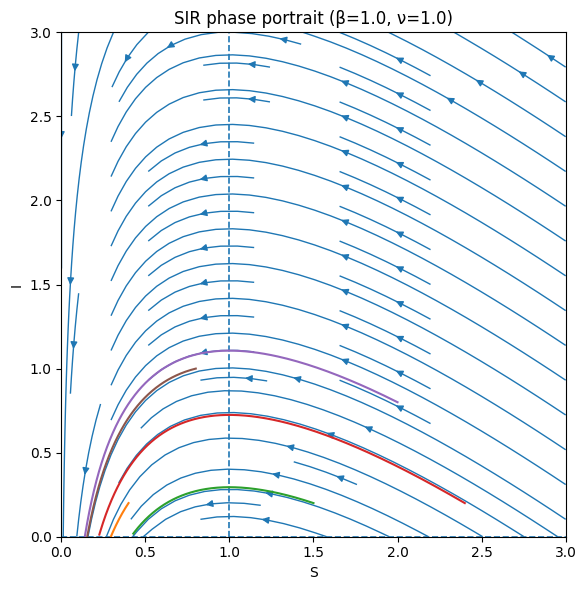

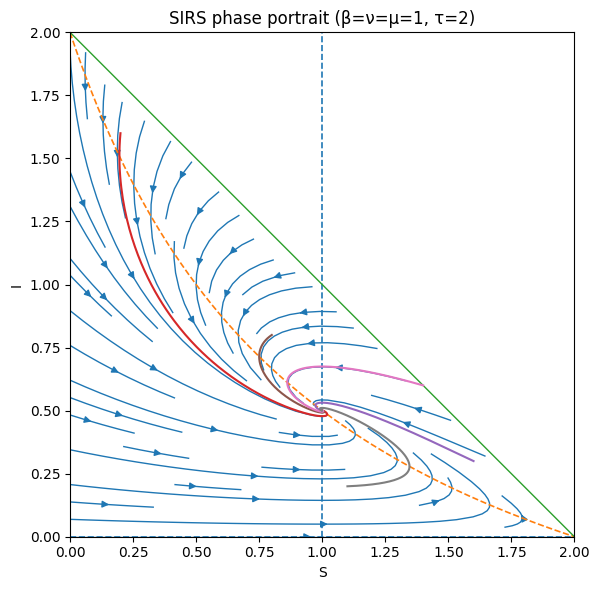

In [4]:
# Phase portraits for SIR and SIRS models
# - Uses matplotlib (no seaborn), one figure per chart, no explicit colors.

import numpy as np
import matplotlib.pyplot as plt


# -------------------------
# 공용: 간단한 RK4 적분기
# -------------------------
def rk4(f, y0, t0, t1, h):
    """y' = f(t, y)를 RK4로 적분."""
    t = np.arange(t0, t1 + 1e-12, h) if t1 >= t0 else np.arange(t0, t1 - 1e-12, -h)
    y = np.zeros((t.size, y0.size))
    y[0] = y0
    for k in range(t.size - 1):
        tk = t[k]
        yk = y[k]
        hstep = t[k + 1] - tk
        k1 = f(tk, yk)
        k2 = f(tk + 0.5 * hstep, yk + 0.5 * hstep * k1)
        k3 = f(tk + 0.5 * hstep, yk + 0.5 * hstep * k2)
        k4 = f(tk + hstep, yk + hstep * k3)
        y[k + 1] = yk + (hstep / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return t, y


# -------------------------
# (c) SIR: S' = -β S I,  I' = I(β S - ν)
# -------------------------
def plot_sir(beta=1.0, nu=1.0, Smax=3.0, Imax=3.0):
    def field(S, I):
        return -beta * S * I, I * (beta * S - nu)

    # 방향장
    S = np.linspace(0.0, Smax, 41)
    I = np.linspace(0.0, Imax, 41)
    SS, II = np.meshgrid(S, I)
    dS, dI = field(SS, II)

    plt.figure(figsize=(6.2, 6.0))
    plt.streamplot(SS, II, dS, dI, density=1.0, linewidth=1.0, arrowsize=1.0)
    plt.xlim(0.0, Smax)
    plt.ylim(0.0, Imax)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(f"SIR phase portrait (β={beta}, ν={nu})")

    # 널클라인: I=0, S=ν/β
    plt.axhline(0.0, linestyle='--', linewidth=1.2)
    plt.axvline(nu / beta, linestyle='--', linewidth=1.2)

    # 몇 개의 궤적
    def rhs(t, y):
        s, i = y
        ds, di = field(s, i)
        return np.array([ds, di])

    inits = [np.array([0.4, 0.2]),
             np.array([1.5, 0.2]),
             np.array([2.4, 0.2]),
             np.array([2.0, 0.8]),
             np.array([0.8, 1.0])]
    for y0 in inits:
        _, y = rk4(rhs, y0, 0.0, 8.0, 0.01)
        y[:, 0] = np.clip(y[:, 0], 0.0, Smax)
        y[:, 1] = np.clip(y[:, 1], 0.0, Imax)
        plt.plot(y[:, 0], y[:, 1])

    plt.xlabel("S")
    plt.ylabel("I")
    plt.tight_layout()
    plt.show()


# -------------------------
# (f) SIRS:  S' = -β S I + μ(τ - S - I),  I' = I(β S - ν)
# (예시) β=ν=μ=1, τ=2
# -------------------------
def plot_sirs(beta=1.0, nu=1.0, mu=1.0, tau=2.0):
    def field(S, I):
        dS = -beta * S * I + mu * (tau - S - I)
        dI = I * (beta * S - nu)
        return dS, dI

    S = np.linspace(0.0, tau, 61)
    I = np.linspace(0.0, tau, 61)
    SS, II = np.meshgrid(S, I)
    dS, dI = field(SS, II)

    # 허용 삼각영역 S+I <= τ 바깥은 마스킹
    mask = (SS + II) > tau + 1e-12
    dS[mask] = np.nan
    dI[mask] = np.nan

    plt.figure(figsize=(6.2, 6.0))
    plt.streamplot(SS, II, dS, dI, density=1.0, linewidth=1.0, arrowsize=1.0)
    plt.xlim(0.0, tau)
    plt.ylim(0.0, tau)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(f"SIRS phase portrait (β=ν=μ={beta:.0f}, τ={tau:.0f})")

    # 널클라인: I'=0 → I=0, S=ν/β
    plt.axhline(0.0, linestyle='--', linewidth=1.2)
    plt.axvline(nu / beta, linestyle='--', linewidth=1.2)
    # S'=0 → -β S I + μ(τ - S - I)=0  ⇒ I = μ(τ - S)/(β S + μ)
    S_curve = np.linspace(0.0, tau, 400)
    I_curve = mu * (tau - S_curve) / (beta * S_curve + mu)
    I_curve[I_curve < 0] = np.nan
    plt.plot(S_curve, I_curve, linestyle='--', linewidth=1.2)

    # 경계 S+I=τ
    Sb = np.linspace(0.0, tau, 200)
    Ib = tau - Sb
    plt.plot(Sb, Ib, linewidth=1.0)

    # 몇 개의 궤적
    def rhs(t, y):
        s, i = y
        ds, di = field(s, i)
        return np.array([ds, di])

    inits = [np.array([0.2, 1.6]),
             np.array([1.6, 0.3]),
             np.array([0.8, 0.8]),
             np.array([1.4, 0.6]),
             np.array([1.1, 0.2])]
    for y0 in inits:
        _, y = rk4(rhs, y0, 0.0, 25.0, 0.02)
        y[:, 0] = np.clip(y[:, 0], 0.0, tau)
        y[:, 1] = np.clip(y[:, 1], 0.0, tau)
        over = (y[:, 0] + y[:, 1]) > tau
        y[over, 1] = tau - y[over, 0]  # 삼각영역 밖 표시 방지
        plt.plot(y[:, 0], y[:, 1])

    plt.xlabel("S")
    plt.ylabel("I")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # (c)
    plot_sir(beta=1.0, nu=1.0)
    # (f)
    plot_sirs(beta=1.0, nu=1.0, mu=1.0, tau=2.0)
